In [1]:
import tensorflow as tf
import tensornets as nets
import os
import random
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import skimage.transform
import pandas as pd

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## Data Loading and Preparation

In [2]:
%%time
#Get image location path
ROOT_DIR = os.getcwd()
IMAGE_DIR = os.path.join(ROOT_DIR, "95-891-hw3/images")
file_names = next(os.walk(IMAGE_DIR))[2]

#Create dictionary for location names
locations = {0:'Austria', 
             1:'Spain', 
             2: 'Estonia',
             3: 'Belgium',
             4: 'Canada',
             5: 'Japan', 
             6: 'China',
             7: 'Australia',
             8: 'Scotland', 
             9: 'Sweden'}

#Get training & testing labels
#Training labels
df = pd.read_csv('95-891-hw3/HW3_train.csv', header = None)
df = df.drop(1, axis=1)
train_img_ids = df.values[:,0]
train_labels = df.values[:,1]

#Testing labels
df = pd.read_csv('95-891-hw3/HW3_test.csv', header = None)
df = df.drop(1, axis=1)
test_img_ids = df.values[:,0]
test_labels = df.values[:,1]

#Load images and resize to fit format for model
train_file_names = []
test_file_names = []
for name in file_names:
    if (name.split(".")[1] == 'jpg'):
        if (name.split('.')[0] in train_img_ids):
            train_file_names.append(name)
        elif (name.split('.')[0] in test_img_ids):
            test_file_names.append(name)
print("Total images:", len(file_names))
print("Training images:", len(train_file_names))
print("Testing images: ", len(test_file_names))

Total images: 33710
Training images: 27000
Testing images:  3317
CPU times: user 17.8 s, sys: 120 ms, total: 17.9 s
Wall time: 17.7 s


In [3]:
#Order file names and labels to be in same sequence
train_labels_dict = dict(zip(train_img_ids, train_labels))
test_labels_dict = dict(zip(test_img_ids, test_labels))

y_train = []
for name in train_file_names:
    y_train.append(train_labels_dict[name.split('.')[0]])

y_test = []
for name in test_file_names:
    y_test.append(test_labels_dict[name.split('.')[0]])
    
print("Train Data:", len(y_train))
print("Test Data:", len(y_test))

Train Data: 27000
Test Data: 3317


In [4]:
%%time
##Load and resize images for training
X_train= np.zeros((len(train_file_names),224,224,3))

for i, name in enumerate(train_file_names):
    newImage = skimage.transform.resize(skimage.io.imread(os.path.join(IMAGE_DIR, name)), (224, 224), mode='constant')
    X_train[i] = newImage

print(X_train.shape)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(27000, 224, 224, 3)
CPU times: user 3min 8s, sys: 7.73 s, total: 3min 16s
Wall time: 3min 16s


In [5]:
%%time
##Load and resize images for testing
X_test = np.zeros((len(test_file_names),224,224,3))
for i, name in enumerate(test_file_names):
    newImage = skimage.transform.resize(skimage.io.imread(os.path.join(IMAGE_DIR, name)), (224, 224), mode='constant')
    X_test[i] = newImage

print(X_test.shape)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(3317, 224, 224, 3)
CPU times: user 23.2 s, sys: 908 ms, total: 24.1 s
Wall time: 24.1 s


Label: Austria


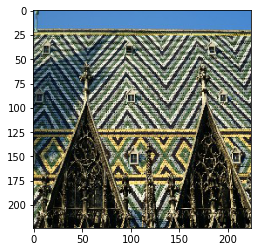

Label: Scotland


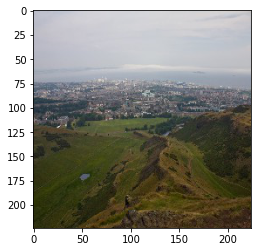

Label: China


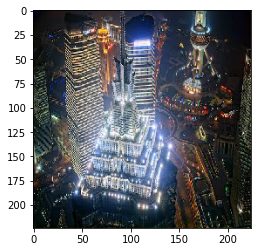

In [6]:
#Show some examples of images and labels
print("Label:", locations[y_train[0]])
plt.imshow(X_train[0])
plt.show()

print("Label:", locations[y_train[50]])
plt.imshow(X_train[50])
plt.show()

print("Label:", locations[y_train[300]])
plt.imshow(X_train[300])
plt.show()

In [7]:
#Delete variables no longer needed
del df
del train_labels_dict
del test_labels_dict

In [8]:
#Convert labels to categorical OHE outputs
from keras.utils import to_categorical
y_test_binary= to_categorical(y_test)
y_train_binary = to_categorical(y_train)

Using TensorFlow backend.


## Model Training

In [9]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [10]:
#Using VGG19 pretrained model from tensornets, pre-trained on 1.2million labeled images from imagenet
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
model.summary() #original VGG19 structure

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
#Freeze blocks 1-4 (layers 1-16)
#Train block 5 (layers 17-22) on our training data set
for layer in model.layers[:17]:
    layer.trainable = False

#Adding custom Layers to learn weights specific to this task 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x) #predict our 10 landmark classes

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.01, momentum=0.4), 
                    metrics=["accuracy"])

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


In [44]:
#Show final model layer summary with added layers
print("Final Model Architecture\nNumber of Layers:", len(model_final.layers))
model_final.summary()

Final Model Architecture
Number of Layers: 27
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (

In [14]:
%%time
# Training the model 
model_history = model_final.fit(
    X_train, y_train_binary,
    epochs = 12,
    validation_split = 0.2,
    batch_size = 128,
    callbacks = [checkpoint, early])

Train on 21600 samples, validate on 5400 samples
Epoch 1/12
21600/21600 [==============================] - 356s 17ms/step - loss: 0.9263 - acc: 0.6947 - val_loss: 0.4157 - val_acc: 0.8667

Epoch 00001: val_acc improved from -inf to 0.86667, saving model to vgg16_1.h5
Epoch 2/12
21600/21600 [==============================] - 335s 15ms/step - loss: 0.3620 - acc: 0.8840 - val_loss: 0.3118 - val_acc: 0.8969

Epoch 00002: val_acc improved from 0.86667 to 0.89685, saving model to vgg16_1.h5
Epoch 3/12
21600/21600 [==============================] - 334s 15ms/step - loss: 0.2283 - acc: 0.9263 - val_loss: 0.3118 - val_acc: 0.9020

Epoch 00003: val_acc improved from 0.89685 to 0.90204, saving model to vgg16_1.h5
Epoch 4/12
21600/21600 [==============================] - 332s 15ms/step - loss: 0.1568 - acc: 0.9494 - val_loss: 0.1734 - val_acc: 0.9437

Epoch 00004: val_acc improved from 0.90204 to 0.94370, saving model to vgg16_1.h5
Epoch 5/12
21600/21600 [==============================] - 333s 15m

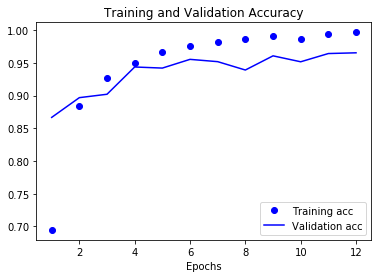

In [46]:
%matplotlib inline
# plot the accuracy rates for each epoch on training and validation data
import matplotlib.pyplot as plt
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Predicting and Evaluating the Test Data

## Question 1

In [42]:
#Predict on the test data
predictions = model_final.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions.argmax(axis=1))

print("Correct Classifications:", np.trace(cm))
print("Total Classifications Made:", len(y_test))
print("Test Accuracy:", '{:0.4f}'.format(np.trace(cm)/ len(y_test)))

Correct Classifications: 3206
Total Classifications Made: 3317
Test Accuracy: 0.9665


## Question 2

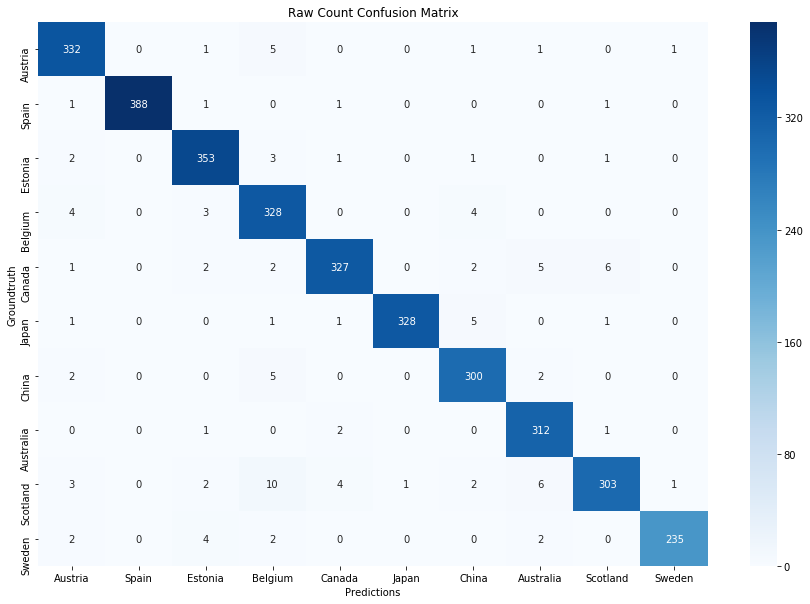

In [48]:
#Plot confusion matrix on a heatmap
import seaborn as sns
plt.figure(figsize = (15,10))
ticks = locations.values()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ticks, yticklabels=ticks)
plt.title("Raw Count Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Groundtruth")
plt.show()

## Question 3

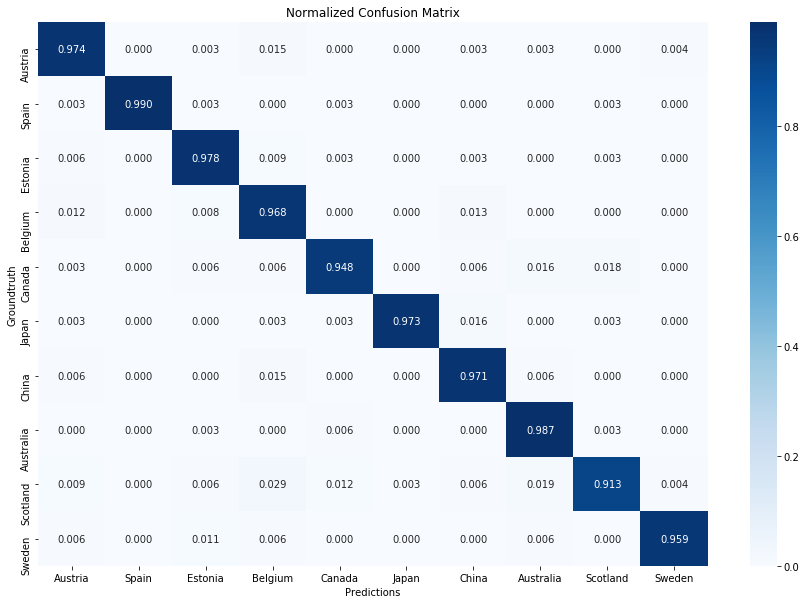

In [47]:
#Normalized confusion matrix
np.set_printoptions
cm_normalized = cm / cm.astype(np.float).sum(axis=1)
cm_normalized.round(decimals=3)

ticks = locations.values()
plt.figure(figsize = (15,10))
sns.heatmap(cm_normalized, annot=True, cmap = "Blues", fmt='0.3f', xticklabels=ticks, yticklabels=ticks)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Groundtruth")
plt.show()

## Question 4

The most accurately predicted landmark is Teide, Spain which has a 99% true positive accuracy rate. 

## Question 5

The least accurately prediced landmark is Edinburgh, Scotland with a 91.3% true positive accuracy rate. This location is most confused Brugge, Belgium. 2.9% of pictures from Scotland are predicted as Belgium. This may be because these two countries are located near each other and may have similar acrchitecture and buildings which would make them difficult to tell apart. Also Scotland may not have a very distinct landmark that makes it easy to tell apart from other locations. 

In [19]:
#Define functions to calculate precision and recall values
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

## Question 6

In [39]:
print("Label Location                         Precision Recall")
print("--------------------------------------------------------")
precision_scores = []
recall_scores = []
for label in range(10):
    precision_scores.append(precision(label,cm))
    recall_scores.append(recall(label,cm))
    print(f"{label:5d} {locations[label]:30s} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

Label Location                         Precision Recall
--------------------------------------------------------
    0 Austria                            0.954  0.974
    1 Spain                              1.000  0.990
    2 Estonia                            0.962  0.978
    3 Belgium                            0.921  0.968
    4 Canada                             0.973  0.948
    5 Japan                              0.997  0.973
    6 China                              0.952  0.971
    7 Australia                          0.951  0.987
    8 Scotland                           0.968  0.913
    9 Sweden                             0.992  0.959


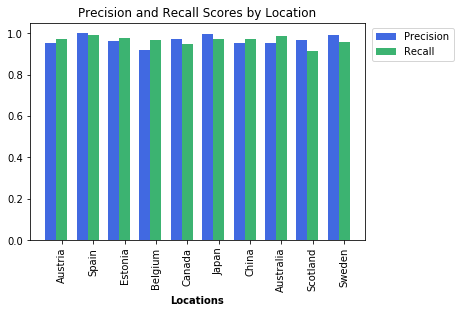

In [21]:
#Plot grouped bar chart
barWidth = 0.35
r1 = np.arange(len(precision_scores))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, precision_scores, color='royalblue', width=barWidth, label='Precision')
plt.bar(r2, recall_scores, color='mediumseagreen', width=barWidth, label='Recall')

plt.xlabel('Locations', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(precision_scores))], locations.values())
plt.xticks(rotation=90)

plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))
plt.title('Precision and Recall Scores by Location')
plt.show()

## References

https://towardsdatascience.com/transfer-learning-in-tensorflow-9e4f7eae3bb4

https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

https://www.python-course.eu/confusion_matrix.php